# ERO2 : Un petit TP

Ce document est à compléter, il sert d'évaluation sommative pour la première itération du cours d'ERO2. Merci de formuler vos questions sur le forum moodle prévu à cet effet.

In [1]:
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt

## *Given Files*

Cette section regroupe les éléments déjà préalablement à votre disposition, vous êtes libres de vous en servir pour répondre aux différentes questions du TP.

In [3]:
class Wline():

    def __init__(self, size=None, policy=(lambda x: 0)):
        self.size = size
        self.next = policy
        
    def populate(self, queue):
        self.queue = queue
    
    def pop(self):
        pop_ix = self.next(self.queue)
        pop_val = None

        if - len(self.queue) < pop_ix < len(self.queue) :
            pop_val = self.queue[pop_ix]
            self.queue.pop(pop_ix)
            
        return pop_val

In [4]:
class InService():
    
    def __init__(self, nb=1, dist=None):
        self.nb = nb
        self.server = [None]*nb
        self.dist = dist
        
    def full(self):
        return not (None in self.server)
        
    def leaving(self, tops):
        
        agent_id = None
        
        if not self.full():
            #Extract index of an available server
            srv_ix = self.server.index(None) 
        
        else:
            #Find agent of smallest departure time, needs to be float to use idxmin
            agent_id = tops.loc[self.server, 't_depart_sys'].astype(float).idxmin()
            #Extract server number of departing agent
            srv_ix = self.server.index(agent_id) 
        
        return srv_ix, agent_id

In [5]:
class QS():
    
    def __init__(self, arval_dist, srv_dist, servers_nb, 
                 queue_size=None, policy=lambda x:0, test_size=100) :
         
        #Initializing metadata
        self.arval_dist = arval_dist
        self.srv_dist = srv_dist
        self.srv_z = servers_nb
        self.queue_z = queue_size if queue_size else test_size
        self.test_z = test_size

        #Initializing Waiting Line
        self.wline = Wline(size=queue_size, policy=policy)
        
        #Initializing In Service List
        self.inservice = InService(nb=servers_nb, dist=srv_dist)
        
        #Initializin tops dataframe
        column_names = ['t_arval_queue', 't_arval_srv', 't_depart_sys']
        self.tops = pd.DataFrame(np.empty((test_size, 3),dtype=object), columns=column_names)
        
    def pretreat(self):
        
        #Easing naming
        tops = self.tops

        t_interarvals = self.arval_dist(size=(self.test_z))
        tops.loc[0, 't_arval_queue'] = t_interarvals[0]
                
        for agent in range(1, self.test_z) :
            tops.loc[agent, 't_arval_queue'] = tops.loc[agent - 1, 't_arval_queue'] + t_interarvals[agent]
        
    def run(self):
        
        #Easing naming
        wline = self.wline
        inservice = self.inservice
        tops = self.tops
        
        #Initializing arrival queue
        wline.queue = list(tops.loc[0:0].index)
        #Initializing upcomgin theoretical arrival        
        buffer_ix = 1 
    
        while buffer_ix < self.test_z:
            
            _next = wline.pop()
            if _next is not None: #Waiting line is not empty 
               # print(f"_next : {_next}")
               # print(f"arrival of next : {tops.loc[_next, 't_arval_queue']}")

                #Update server arrival time as if no waiting was needed
                tops.loc[_next, 't_arval_srv'] = tops.loc[_next, 't_arval_queue']
                
                #Find next available server
                srv_ix, dept_ag = inservice.leaving(tops)
    
                #Fill available server with corresponding next agent in waiting line
                inservice.server[srv_ix] = _next 
                    
                if dept_ag is not None :
                    if tops.loc[_next, 't_arval_queue'] < tops.loc[dept_ag, 't_depart_sys'] : 
                        #Update server arrival time in case arrival is before system departure
                        tops.loc[_next, 't_arval_srv'] = tops.loc[dept_ag, 't_depart_sys']
                        
                #Update system departure time
                tops.loc[_next, 't_depart_sys'] = tops.loc[_next, 't_arval_srv'] + inservice.dist() 
                                            
            #Counting prior agents still in system
            in_system = (tops.loc[0:buffer_ix - 1, 't_depart_sys'] > tops.loc[buffer_ix, 't_arval_queue']).sum()
                            
            if self.queue_z is not None and in_system >= self.queue_z + self.inservice.nb:
                tops.loc[buffer_ix, 't_depart_sys'] = -1
            else:
                wline.queue.append(buffer_ix)
                    
            buffer_ix += 1
                
    def posttreat(self):
        
        #Easing naming
        tops = self.tops
        
        tops['t_sojourn'] = np.where(tops['t_depart_sys'] == -1, 0, tops['t_depart_sys'] - tops['t_arval_queue'])
        tops['t_waiting'] = np.where(tops['t_depart_sys'] == -1, 0, tops['t_arval_srv'] - tops['t_arval_queue'])
        tops['t_service'] = np.where(tops['t_depart_sys'] == -1, 0, tops['t_depart_sys'] - tops['t_arval_srv'])
        tops['blocked'] = tops.loc[:,'t_depart_sys'] == -1
        tops['waited'] = tops['t_waiting'] > 0 
    
    def timeline(self, t_delation=2):
        
        #Easing naming
        tops = self.tops
        test_z = self.test_z

        # Process determination
        colnames = ['ag_in_sys', 'ag_in_queue', 'ag_in_service']
        t_range = np.linspace(0., tops['t_depart_sys'].max(), t_delation*test_z)
        process = pd.DataFrame(np.empty((t_range.shape[0], 3),dtype=object), 
                                index=t_range, columns=colnames)
        
        for t in process.index:
            process.loc[t, 'ag_in_sys'] = ((t >= tops['t_arval_queue']) & (t <= tops['t_depart_sys'])).sum()
            process.loc[t, 'ag_in_queue'] = ((t >= tops['t_arval_queue']) & (t <= tops['t_arval_srv'])).sum()
            process.loc[t, 'ag_in_service'] = ((t > tops['t_arval_srv']) & (t <= tops['t_depart_sys'])).sum()
        
        # Statistics extractions
        statnames = ['mean_sojourn_time', 'mean_waiting_time', 'mean_service_time', 
                     'waiting_proportion', 'blocked_proportion', 'servers_max_usage']
        stats = pd.DataFrame(np.empty((len(statnames), 1),dtype=object), index=statnames, columns=['run value'])
 
        stats.loc['mean_sojourn_time'] = tops['t_sojourn'].sum() / (~tops['blocked']).sum()
        stats.loc['mean_waiting_time'] = tops['t_waiting'].sum() / (~tops['blocked']).sum()
        stats.loc['mean_service_time'] = tops['t_service'].sum() / (~tops['blocked']).sum()

        stats.loc['waiting_proportion'] = tops['waited'].sum() / (~tops['blocked']).sum()
        stats.loc['blocked_proportion'] = tops['blocked'].sum() / test_z

        # An approximation of server usage, for better approximation raise t_delation.
        stats.loc['servers_max_usage'] = (process['ag_in_service'] == self.inservice.nb).sum() / (t_delation*test_z - 1)

        return process, stats

# Question 1

1. Comparer les comportements de files M/M/1/k et M/M/1/k/LIFO au regard des métriques qui vous semblent pertinentes. Appuyez vos conclusions de simulations et contextualisez vos choix.
2. Vos conclusions changent-elles dans le cas des M/M/1 et M/M/1/LIFO ?

In [6]:
rng = np.random.default_rng(seed=42)

In [7]:
srv_nb = 1
arval_dist = lambda size : rng.exponential(1./40, size=size)
srv_dist = lambda :  rng.exponential(1./4.)
fifo_policy = lambda x : 0
lifo_policy = lambda x : (-1)

In [8]:
mm1_fifo = QS(arval_dist, srv_dist, srv_nb, queue_size=10, test_size=100, policy=fifo_policy)

In [9]:
mm1_lifo = QS(arval_dist, srv_dist, srv_nb, queue_size=10, test_size=100, policy=lifo_policy)

In [10]:
mm1_fifo.pretreat()
mm1_lifo.pretreat()

In [11]:
mm1_fifo.run()
mm1_lifo.run()

In [12]:
mm1_fifo.posttreat()
mm1_lifo.posttreat()

In [13]:
mm1_fifo_bench, mm1_fifo_stats = mm1_fifo.timeline()
mm1_lifo_bench, mm1_lifo_stats = mm1_lifo.timeline()

In [14]:
mm1_fifo_stats.join(mm1_lifo_stats, lsuffix="_fifo", rsuffix="_lifo")

,run value_fifo,run value_lifo
mean_sojourn_time,1.581122,2.177111
mean_waiting_time,1.382879,1.906979
mean_service_time,0.198242,0.270132
waiting_proportion,0.904762,0.909091
blocked_proportion,0.79,0.78
servers_max_usage,0.98995,0.984925


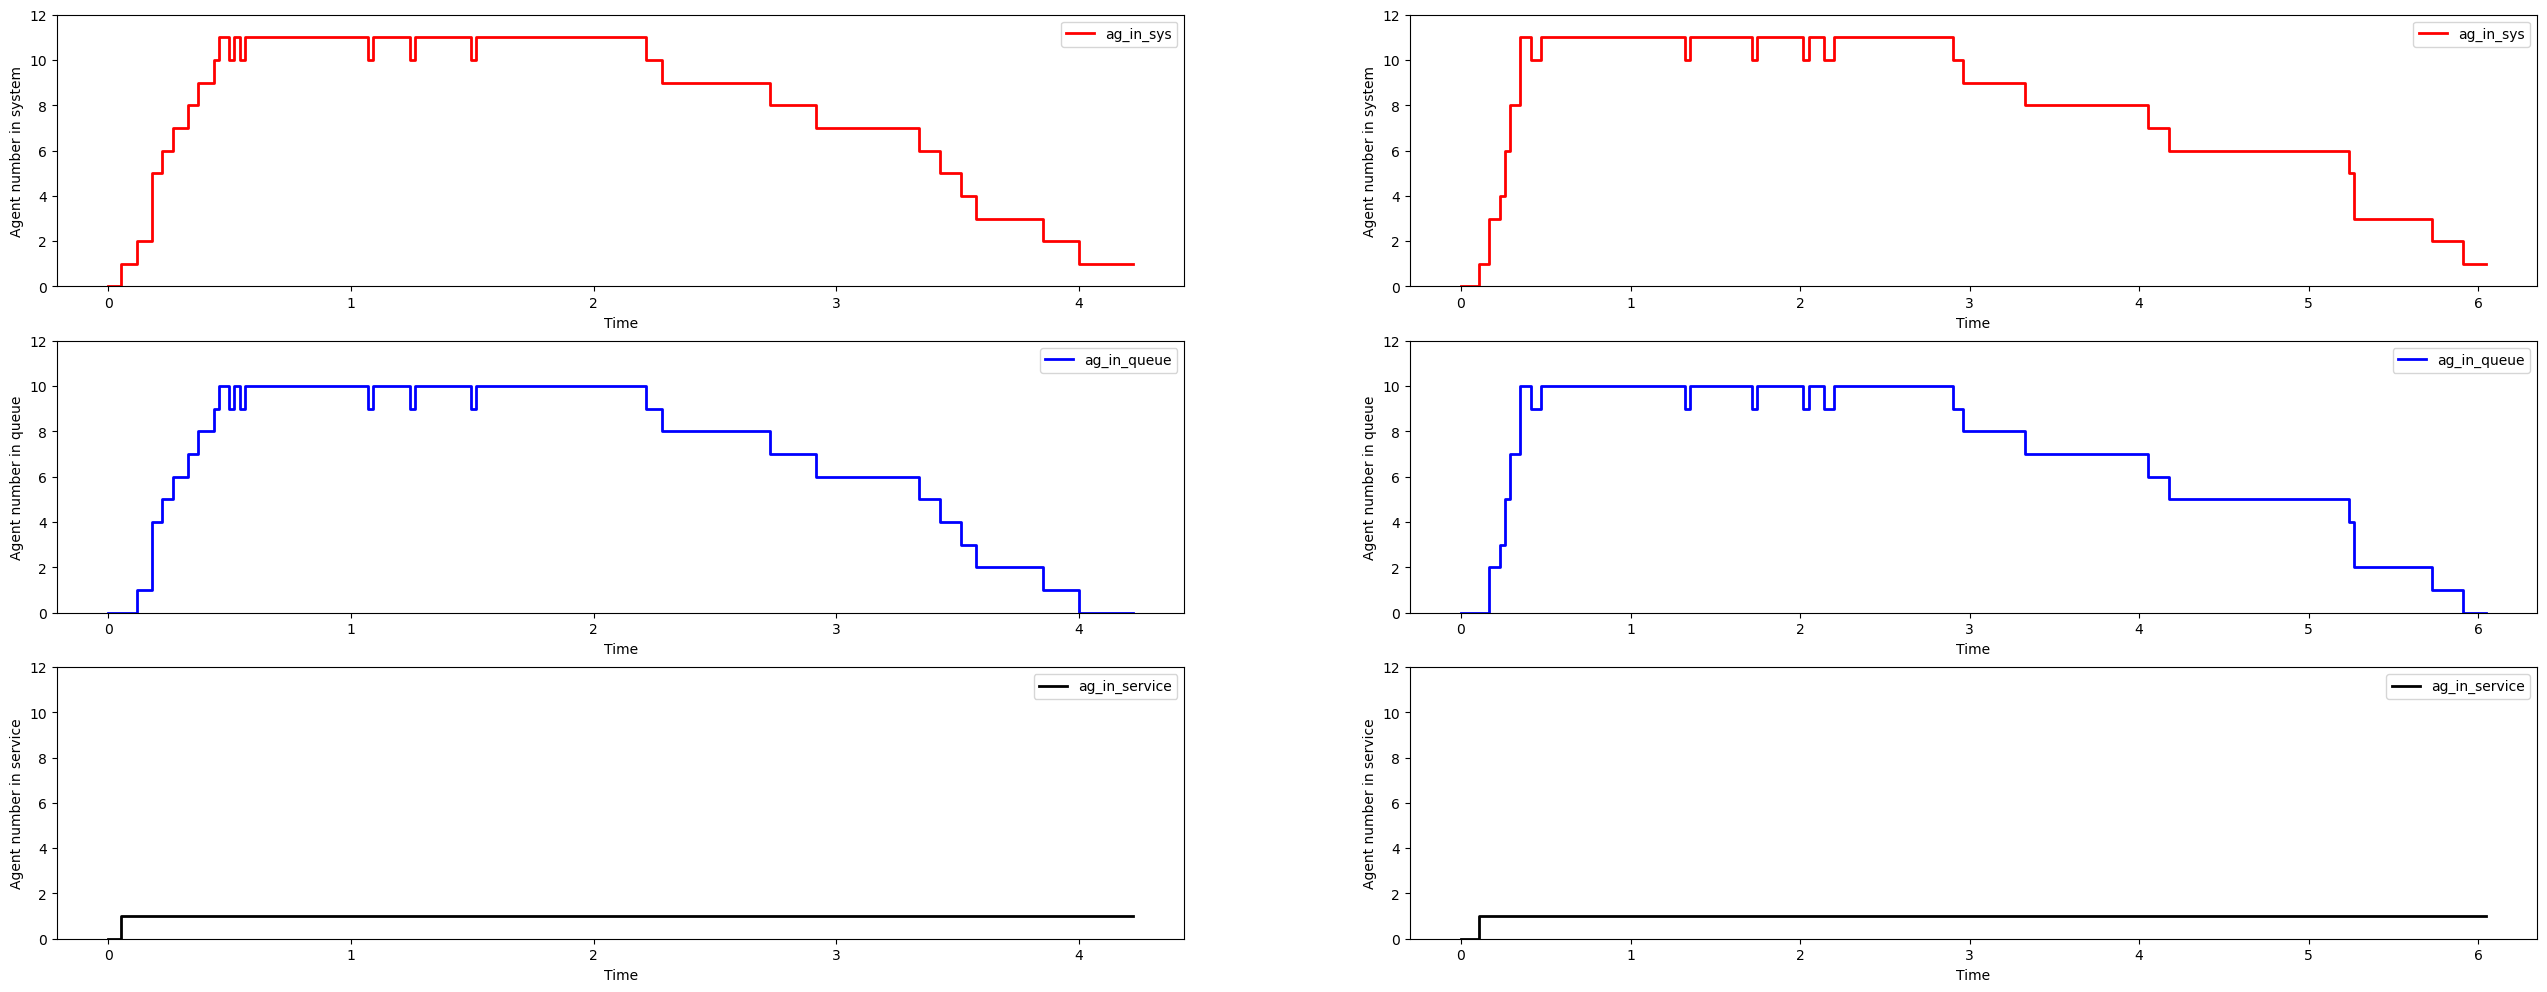

In [15]:
fig, axes = plt.subplots(3, 2, figsize=(32, 12))
counts = ['ag_in_sys','ag_in_queue','ag_in_service']
labels = ['system', 'queue', 'service']
colors = ['red', 'blue', 'black']

for i in range(3):
    mm1_fifo_bench.plot(y= counts[i], 
                   use_index=True, ax=axes[i,0], linewidth=2,drawstyle='steps-mid', color=f'{colors[i]}',
                   ylabel=f'Agent number in {labels[i]}', xlabel='Time', ylim=[0,max(mm1_fifo_bench['ag_in_sys']+1)])
    
    mm1_lifo_bench.plot(y= counts[i], 
                   use_index=True, ax=axes[i,1], linewidth=2,drawstyle='steps-mid', color=f'{colors[i]}',
                   ylabel=f'Agent number in {labels[i]}', xlabel='Time', ylim=[0,max(mm1_lifo_bench['ag_in_sys']+1)])

# Question 2

On suppose avoir à diposition $5$ serveurs $s_1$, $\ldots$, $s_5$ et $3$ files d'arrivées *FIFO* $f_1$, $f_1$, $f_3$ de tailles respectives $z_1$, $z_2$, $z_3$. Les temps de services de nos serveurs sont respectivements donnés par des lois exponentielles paramètres $\mu_1$, $\ldots$, $\mu_5$, ordonnés par ordre croissant.  

Une population d'agents s'adresse à notre service, déployé identitiquement sur chaque serveur. On constate que cette population est décomposée en $5$ sous-populations $A_1$, $\ldots$, $A_5$ dont les processus d'arrivées sont respectivement d'intensités $\lambda_1$, $\ldots$, $\lambda_5$, ordonnés par ordre croissants. Les tailles respectives de chacune des populations sont $a_1$, $\ldots$, $a_5$ ; elles vérifient les relations $a_i > 2\max\{z_1, z_2, z_3\}$ pour tout $1 \leq i \leq 3$.   

1. Simuler un système d'attente qui permet de répondre aux besoins de services.
2. Comparer un minimum de trois architectures possibles, au regard des ressources à disposition, pour répondre aux besoins de services. Vous êtes attendus sur des simulations appuyants vos propos.
3. Quelles modifications apporteriez-vous sur votre proposition si l'on introduit une fonction de dissatisfaction des agents donnée par $ b_1 + 2 b_2 + \cdots 5 b_5$, où $b_i$ correspond au nombre d'agents de la populations $A_i$ qui n'ont pas pu avoir accès au système ?

Vous êtes autorisé d'effectuer des hypothèses simplificatrices dans votre travail. Attention à ce qu'elles ne soient pas *trop* simplificatrices.